## Перенос стиля с pix2pix

Во многом этот ноутбук основан на туториале с документации tensorflow: https://www.tensorflow.org/tutorials/generative/pix2pix?hl=en

In [2]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torchvision.io import read_image

Построим пайплайн для загрузки и обработки изображений.

Сделаем простые аугментации:

- resize
- random crop
- random mirror

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = pathlib.Path(root)
        self.transform = transform
        self.files = list(self.root.glob('*.jpg'))
        self.files = [str(path) for path in self.files]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        image = read_image(self.files[index])
        # image = image.permute(1, 2, 0)
        # image = image.numpy()

        width = image.shape[2]

        input_image = image[:, :, :width // 2]
        real_image = image[:, :, width // 2:]

        if self.transform:
            input_image, real_image = self.transform(input_image, real_image)
        return input_image, real_image

In [4]:
def resize(input_image, real_image, height, width):
    #input_image = input_image.permute(2, 0, 1)
    #real_image = real_image.permute(2, 0, 1)

    input_image = torchvision.transforms.Resize((height, width))(input_image)
    real_image = torchvision.transforms.Resize((height, width))(real_image)

    #input_image = input_image.permute(1, 2, 0)
    #real_image = real_image.permute(1, 2, 0)

    return input_image, real_image


def random_crop(input_image, real_image):
    stacked_image = torch.stack((input_image, real_image), dim=0)
    #stacked_image = stacked_image.permute(0, 3, 1, 2)
    cropped_image = torchvision.transforms.RandomCrop(size=(256, 256))(stacked_image)
    #cropped_image = cropped_image.permute(0, 2, 3, 1)
    return cropped_image[0], cropped_image[1]


def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image


def random_jitter(input_image, real_image):
    # resize to 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # randomly crop to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)

    input_image, real_image = normalize(input_image, real_image)

    if np.random.random() > 0.5:
        # random mirroring
        input_image = torch.flip(input_image, dims=[2])
        real_image = torch.flip(real_image, dims=[2])

    return real_image, input_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


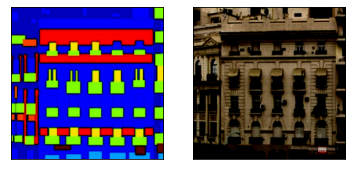

In [5]:
train_dataloader = torch.utils.data.DataLoader(
    Dataset(
        'data/train',
        transform=random_jitter,
    ),
    batch_size=1,
    shuffle=True,
)


test_dataloader = torch.utils.data.DataLoader(
    Dataset('data/test', transform=None),
    batch_size=1,
    shuffle=True,
)


val_dataloader = torch.utils.data.DataLoader(
    Dataset('data/val', transform=random_jitter),
    batch_size=1,
    shuffle=True,
)


def show_batch(dl):
    for input_image, real_image in dl:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.set_xticks([]); ax1.set_yticks([])
        ax2.set_xticks([]); ax2.set_yticks([])
        ax1.imshow(input_image[0].permute(1, 2, 0))
        ax2.imshow(real_image[0].permute(1, 2, 0))
        plt.show()
        break

        
show_batch(train_dataloader)

Зададим архитектуру генератора и дискриминатора.


В качестве генератора возьмем модифицированный U-Net.

In [6]:
class ConvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, activation=True, batch_norm=True):
        super(ConvBlock, self).__init__()
        self.conv = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding)
        self.activation = activation
        self.lrelu = torch.nn.LeakyReLU(0.2, True)
        self.batch_norm = batch_norm
        self.bn = torch.nn.BatchNorm2d(output_size)

    def forward(self, x):
        if self.activation:
            out = self.conv(self.lrelu(x))
        else:
            out = self.conv(x)

        if self.batch_norm:
            return self.bn(out)
        else:
            return out


class DeconvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, batch_norm=True, dropout=False):
        super(DeconvBlock, self).__init__()
        self.deconv = torch.nn.ConvTranspose2d(input_size, output_size, kernel_size, stride, padding)
        self.bn = torch.nn.BatchNorm2d(output_size)
        self.drop = torch.nn.Dropout(0.5)
        self.relu = torch.nn.ReLU(True)
        self.batch_norm = batch_norm
        self.dropout = dropout

    def forward(self, x):
        if self.batch_norm:
            out = self.bn(self.deconv(self.relu(x)))
        else:
            out = self.deconv(self.relu(x))

        if self.dropout:
            return self.drop(out)
        else:
            return out


class Generator(torch.nn.Module):
    def __init__(self, input_dim, num_filter, output_dim):
        super(Generator, self).__init__()

        # Encoder
        self.conv1 = ConvBlock(input_dim, num_filter, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(num_filter, num_filter * 2)
        self.conv3 = ConvBlock(num_filter * 2, num_filter * 4)
        self.conv4 = ConvBlock(num_filter * 4, num_filter * 8)
        self.conv5 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv6 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv7 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv8 = ConvBlock(num_filter * 8, num_filter * 8, batch_norm=False)
        # Decoder
        self.deconv1 = DeconvBlock(num_filter * 8, num_filter * 8, dropout=True)
        self.deconv2 = DeconvBlock(num_filter * 8 * 2, num_filter * 8, dropout=True)
        self.deconv3 = DeconvBlock(num_filter * 8 * 2, num_filter * 8, dropout=True)
        self.deconv4 = DeconvBlock(num_filter * 8 * 2, num_filter * 8)
        self.deconv5 = DeconvBlock(num_filter * 8 * 2, num_filter * 4)
        self.deconv6 = DeconvBlock(num_filter * 4 * 2, num_filter * 2)
        self.deconv7 = DeconvBlock(num_filter * 2 * 2, num_filter)
        self.deconv8 = DeconvBlock(num_filter * 2, output_dim, batch_norm=False)

    def forward(self, x):
        # Encoder
        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        enc4 = self.conv4(enc3)
        enc5 = self.conv5(enc4)
        enc6 = self.conv6(enc5)
        enc7 = self.conv7(enc6)
        enc8 = self.conv8(enc7)
        # Decoder with skip-connections
        dec1 = self.deconv1(enc8)
        dec1 = torch.cat([dec1, enc7], 1)
        dec2 = self.deconv2(dec1)
        dec2 = torch.cat([dec2, enc6], 1)
        dec3 = self.deconv3(dec2)
        dec3 = torch.cat([dec3, enc5], 1)
        dec4 = self.deconv4(dec3)
        dec4 = torch.cat([dec4, enc4], 1)
        dec5 = self.deconv5(dec4)
        dec5 = torch.cat([dec5, enc3], 1)
        dec6 = self.deconv6(dec5)
        dec6 = torch.cat([dec6, enc2], 1)
        dec7 = self.deconv7(dec6)
        dec7 = torch.cat([dec7, enc1], 1)
        dec8 = self.deconv8(dec7)
        out = torch.nn.Tanh()(dec8)
        return out

    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal_(m.conv.weight, mean, std)
            if isinstance(m, DeconvBlock):
                torch.nn.init.normal_(m.deconv.weight, mean, std)


class Discriminator(torch.nn.Module):
    def __init__(self, input_dim, num_filter, output_dim):
        super(Discriminator, self).__init__()

        self.conv1 = ConvBlock(input_dim, num_filter, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(num_filter, num_filter * 2)
        self.conv3 = ConvBlock(num_filter * 2, num_filter * 4)
        self.conv4 = ConvBlock(num_filter * 4, num_filter * 8, stride=1)
        self.conv5 = ConvBlock(num_filter * 8, output_dim, stride=1, batch_norm=False)

    def forward(self, x, y):
        x = torch.cat([x, y], 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        out = torch.nn.Sigmoid()(x)
        return out

    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal_(m.conv.weight, mean, std)

In [7]:
criterion = torch.nn.BCEWithLogitsLoss()


def gen_loss(disc_generated_output, gen_output, target, criterion=criterion, LAMBDA=100):
    gan_loss = criterion(disc_generated_output, torch.ones_like(disc_generated_output))
    l1_loss = torch.nn.L1Loss()(gen_output, target)
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output, criterion=criterion):
    real_loss = criterion(disc_real_output, torch.ones_like(disc_real_output))
    generated_loss = criterion(disc_generated_output, torch.zeros_like(disc_generated_output))
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [8]:
gen = Generator(3, 64, 3)
disc = Discriminator(6, 64, 1)


gen.normal_weight_init(mean=0.0, std=0.02)
disc.normal_weight_init(mean=0.0, std=0.02)

# gen = Generator()
# disc = Discriminator()

In [9]:
gen_optim = torch.optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
disc_optim = torch.optim.Adam(disc.parameters(), lr=2e-4, betas=(0.5, 0.999))


gen_total_loss_history = []
gen_gan_loss_history = []
gen_l1_loss_history = []
disc_loss_history = []


def train_step(input_image, target, generator, discriminator, gen_optim, disc_optim, criterion=criterion, LAMBDA=100):
    # Train Generator
    # with torch.cuda.amp.autocast():
    gen_output = generator(input_image)
    disc_generated_output = discriminator(gen_output, input_image)
    gen_total_loss, gen_gan_loss, gen_l1_loss = gen_loss(disc_generated_output, gen_output, target, criterion, LAMBDA)

    gen_optim.zero_grad()
    gen_total_loss.backward()
    gen_optim.step()

    # Train Discriminator
    # with torch.cuda.amp.autocast():
    disc_real_output = discriminator(target, input_image)
    disc_generated_output = discriminator(gen_output.detach(), input_image)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output, criterion)

    disc_optim.zero_grad()
    disc_loss.backward()
    disc_optim.step()

    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

    
def generate_images(model, test_input, tar):
    prediction = model(test_input)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow((display_list[i] * 0.5 + 0.5).permute(1, 2, 0).detach().numpy())
        plt.axis('off')
    plt.show()


def fit(train_dataset, val_dataset, epochs):
    import time
    from IPython.display import clear_output

    example_input, example_target = next(iter(val_dataset))

    show_batch(val_dataloader)

    for epoch in range(epochs):
        start = time.time()

        for step, (input_image, target) in enumerate(train_dataset):
            print("step ", step, " of ", len(train_dataset), " in epoch ", epoch, " of ", epochs, " epochs")
            if (step) % 10 == 0:
                clear_output(wait=True)

                if step != 0:
                    print(f'Time taken for 10 steps: {time.time()-start:.2f} sec\n')

                start = time.time()
                generate_images(gen, input_image, target)
                print(f"Step: {step//10}k")

            gen_total_loss, gen_gan_loss, gen_l1_loss, discriminator_loss = train_step(input_image, target, gen, disc, gen_optim, disc_optim)

        # display.clear_output(wait=True)
            print(f"Epoch {epoch + 1}")
            print(f"Time taken for epoch {time.time()-start} sec\n")
            print(f"gen_total_loss {gen_total_loss}, gen_gan_loss {gen_gan_loss}, gen_l1_loss {gen_l1_loss}, disc_loss {discriminator_loss}")

        generate_images(gen, example_input, example_target)

Time taken for 10 steps: 29.86 sec



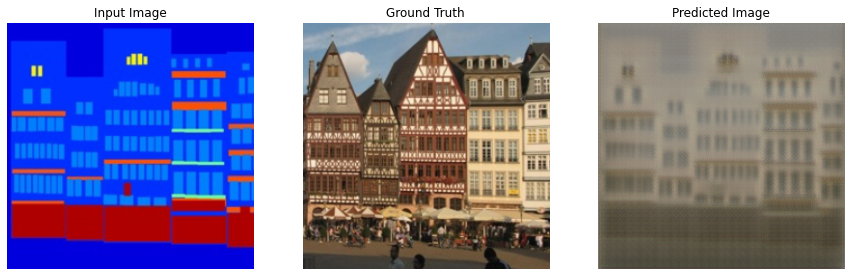

Step: 39k
Epoch 1
Time taken for epoch 3.4693548679351807 sec

gen_total_loss 33.24547576904297, gen_gan_loss 0.6919679641723633, gen_l1_loss 0.3255350887775421, disc_loss 1.0571112632751465
step  391  of  400  in epoch  0  of  1  epochs
Epoch 1
Time taken for epoch 6.869657039642334 sec

gen_total_loss 24.719547271728516, gen_gan_loss 0.6888619661331177, gen_l1_loss 0.24030685424804688, disc_loss 1.0897809267044067
step  392  of  400  in epoch  0  of  1  epochs
Epoch 1
Time taken for epoch 10.266012191772461 sec

gen_total_loss 25.346033096313477, gen_gan_loss 0.6874443888664246, gen_l1_loss 0.2465858906507492, disc_loss 1.0758211612701416
step  393  of  400  in epoch  0  of  1  epochs
Epoch 1
Time taken for epoch 13.128849029541016 sec

gen_total_loss 26.153656005859375, gen_gan_loss 0.6917546987533569, gen_l1_loss 0.2546190023422241, disc_loss 1.058298945426941
step  394  of  400  in epoch  0  of  1  epochs
Epoch 1
Time taken for epoch 15.992209196090698 sec

gen_total_loss 29.11646

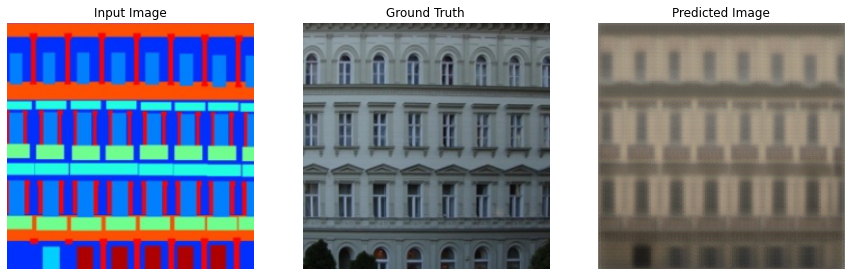

In [10]:
fit(train_dataloader, val_dataloader, epochs=1)


Видим, что уже за одну эпоху модель начинает генерировать отдаленно похожие на ground truth изображения.